# Testing Predictions of the variants of MILD

In [17]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import torch
import os

from mild_hri.utils import *
from mild_hri.dataloaders import *


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

pred_mse = []
pred_mse_nowave = []
pred_mse_wave = []
pred_mse_shake = []
pred_mse_rocket = []
pred_mse_parachute = []
labels = []
vae_mse = []

# epochs = [60]
# epochs = np.arange(0,401,10)
# model_epochs = {
# 					# Buetepage Human-Human
# 					'z5h6':

# 					# Pepper (trial means)
# 					'v1_1/diaghmm_z3h5':400,	'v1_1/diaghmm_z5h5':310,	'v1_1/diaghmm_z8h5':400,
# 					# 'v1_1/diaghmm_z3h6':210,	'v1_1/diaghmm_z5h6':390,	'v1_1/diaghmm_z8h6':380,
# 					# 'v1_1/diaghmm_z3h7':120,	'v1_1/diaghmm_z5h7':400,	'v1_1/diaghmm_z8h7':120,
# 					# 'v1_1/diaghmm_z3h8':360,	'v1_1/diaghmm_z5h8':380,	'v1_1/diaghmm_z8h8':250,

# 					'v2_1/diaghmm_z3h5':330,	'v2_1/diaghmm_z5h5':320,	'v2_1/diaghmm_z8h5':200,
# 					# 'v2_1/diaghmm_z3h6':330,	'v2_1/diaghmm_z5h6':340,	'v2_1/diaghmm_z8h6':360,
# 					# 'v2_1/diaghmm_z3h7':370,	'v2_1/diaghmm_z5h7':290,	'v2_1/diaghmm_z8h7':50,
# 					# 'v2_1/diaghmm_z3h8':70 ,	'v2_1/diaghmm_z5h8':100,	'v2_1/diaghmm_z8h8':360,
					
# 					'v2_2/diaghmm_z3h5':290,	'v2_2/diaghmm_z5h5':360,	'v2_2/diaghmm_z8h5':400,
# 					# 'v2_2/diaghmm_z3h6':350,	'v2_2/diaghmm_z5h6':240,	'v2_2/diaghmm_z8h6':290,
# 					# 'v2_2/diaghmm_z3h7':370,	'v2_2/diaghmm_z5h7':240,	'v2_2/diaghmm_z8h7':110,
# 					# 'v2_2/diaghmm_z3h8':130,	'v2_2/diaghmm_z5h8':100,	'v2_2/diaghmm_z8h8':330,

# 					'v3_1/diaghmm_z3h5':300,	'v3_1/diaghmm_z5h5':380,	'v3_1/diaghmm_z8h5':280,
# 					# 'v3_1/diaghmm_z3h6':380,	'v3_1/diaghmm_z5h6':150,	'v3_1/diaghmm_z8h6':310,
# 					# 'v3_1/diaghmm_z3h7':330,	'v3_1/diaghmm_z5h7':290,	'v3_1/diaghmm_z8h7':310,
# 					# 'v3_1/diaghmm_z3h8':270,	'v3_1/diaghmm_z5h8':390,	'v3_1/diaghmm_z8h8':390,

# 					'v3_2/diaghmm_z3h5':220,	'v3_2/diaghmm_z5h5':210,	'v3_2/diaghmm_z8h5':390,
# 					# 'v3_2/diaghmm_z3h6':170,	'v3_2/diaghmm_z5h6':120,	'v3_2/diaghmm_z8h6':380,
# 					# 'v3_2/diaghmm_z3h7':180,	'v3_2/diaghmm_z5h7':380,	'v3_2/diaghmm_z8h7':350,
# 					# 'v3_2/diaghmm_z3h8':310,	'v3_2/diaghmm_z5h8':370,	'v3_2/diaghmm_z8h8':210,
# 			}

# model_types = ['z5h6'] # HH
# epochs = [180] # nuisiv2_3joints_xvel
# epochs = [400] # bp_hh_20hz_3joints_xvel

model_types = ['v1_1/z5h6', 'v2_1/z5h6', 'v2_2/z5h6', 'v3_1/z5h6', 'v3_2/z5h6'] # HH
epochs = [400] #nuisiv2_pepper_3joints_xvel_old, bp_yumi_20hz_3joints_xvel
# epochs = [190] #bp_pepper_20hz_3joints_xvel_old

print('Model\tEpochs\tTrial\tPred. MSE (all)\t\tPred. MSE w/o waving\t\tPred. MSE waving\t\tPred. MSE handshake\t\tPred. MSE rocket\t\tPred. MSE parachute')
print('.\t.\t.\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma')
# print('Model\tEpochs\tTrial\tPred. MSE (all)\t\tPred. MSE w/o waving\t\tPred. MSE Clapfist\t\tPred. MSE Fistbump\t\tPred. MSE handshake\t\tPred. MSE highfive\t\tPred. MSE rocket\t\tPred. MSE waving')
# print('\t\t\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma\tmean\tsigma')
pred_mse_action = []
for model_type in model_types:
	for epoch in epochs:
		pred_mse_k = []
		pred_mse_action_k = []
		for i in range(4):
			pred_mse_action_k.append([])
		pred_mse_nowave_k = []
		# pred_mse_wave_k = []
		# pred_mse_shake_k = []
		# pred_mse_rocket_k = []
		# pred_mse_parachute_k = []
		for trial in range(4):
			if epoch == 400:
				ckpt_path = f'../logs/2023/nuisiv2_pepper_3joints_xvel/{model_type}/trial{trial}/models/final_399.pth'
			else:
				ckpt_path = f'../logs/2023/nuisiv2_pepper_3joints_xvel/{model_type}/trial{trial}/models/' + '%0.3d'%epoch + '.pth'
	
			ckpt = torch.load(ckpt_path)
			# pred_mse_ckpt, pred_mse_nowave_ckpt, pred_mse_wave_ckpt, pred_mse_shake_ckpt, pred_mse_rocket_ckpt, pred_mse_parachute_ckpt = evaluate_ckpt_hh(ckpt_path)
			pred_mse_ckpt, pred_mse_action_ckpt, pred_mse_nowave_ckpt = evaluate_ckpt_hr(ckpt_path)

			if np.any(np.isnan(pred_mse_ckpt)):
				print(model_type, trial)
				continue
			pred_mse_k += pred_mse_ckpt
			pred_mse_nowave_k += pred_mse_nowave_ckpt
			s = f'{model_type}\t{epoch}\t{trial}\t'#{np.mean(pred_mse_ckpt):.3f} $\pm$ {np.std(pred_mse_ckpt):.3f}\t{np.mean(pred_mse_nowave_ckpt):.3f} $\pm$ {np.std(pred_mse_nowave_ckpt):.3f}'
			for i in range(len(pred_mse_action_ckpt)):
				pred_mse_action_k[i] += pred_mse_action_ckpt[i]
				s += f'\t{np.mean(pred_mse_action_ckpt[i]):.3f} $\pm$ {np.std(pred_mse_action_ckpt[i]):.3f}'
			print(s)
			# pred_mse_wave_k += pred_mse_wave_ckpt
			# pred_mse_shake_k += pred_mse_shake_ckpt
			# pred_mse_rocket_k += pred_mse_rocket_ckpt
			# pred_mse_parachute_k += pred_mse_parachute_ckpt
			# print(f'{model_type}\t{epoch}\t{trial}\t{np.mean(pred_mse_ckpt):.3f} ± {np.std(pred_mse_ckpt):.3f}')#\t{np.mean(pred_mse_nowave_ckpt):.3f} ± {np.std(pred_mse_nowave_ckpt):.3f}\t{np.mean(pred_mse_wave_ckpt):.3f} ± {np.std(pred_mse_wave_ckpt):.3f}\t{np.mean(pred_mse_shake_ckpt):.3f} ± {np.std(pred_mse_shake_ckpt):.3f}\t{np.mean(pred_mse_rocket_ckpt):.3f ± {np.std(pred_mse_rocket_ckpt:.3ft{np.mean(pred_mse_parachute_ckpt:.3f± {np.std(pred_mse_parachute_ckpt)*100:.33f')
		# print(f'{model_type}\t{epoch}\tall\t{np.mean(pred_mse_k):.3f ± {np.std(pred_mse_k**100:.33f')#\t{np.mean(pred_mse_nowave_k:.3f± {np.std(pred_mse_nowave_k):.3f}\t{np.mean(pred_mse_wave_k):.3f} ± {np.std(pred_mse_wave_k):.3ft{np.mean(pred_mse_shake_k)*100:.33f ± {np.std(pred_mse_shake_*100:.33ft{np.mean(pred_mse_rocket_k*100:.33f} ± {np.std(pred_mse_rocket_k:.3f\t{np.mean(pred_mse_parachute_k*:.3f ± {np.std(pred_mse_parachute_k)*100:.33f')
		# s = f'{model_type}\t{epoch}\tall\t{np.mean(pred_mse_k):.3f} $\pm$ {np.std(pred_mse_k):.3f}\t{np.mean(pred_mse_nowave_k):.3f} $\pm$ {np.std(pred_mse_nowave_k):.3f}'
		# for i in range(len(pred_mse_action_k)):
		# 	if len(pred_mse_action_k[i]) == 0:
		# 		continue
		# 	s += f'\t{np.mean(pred_mse_action_k[i]):.3f} $\pm$ {np.std(pred_mse_action_k[i]):.3f}'
		# print(s)
		print('')
	pred_mse_action.append(pred_mse_action_k)
# np.savez_compressed('../logs/mse/bp_yumi_20hz_3joints_xvel.npz', np.array(pred_mse_action,dtype=object))
	# print('\n')


Model	Epochs	Trial	Pred. MSE (all)		Pred. MSE w/o waving		Pred. MSE waving		Pred. MSE handshake		Pred. MSE rocket		Pred. MSE parachute
.	.	.	mean	sigma	mean	sigma	mean	sigma	mean	sigma	mean	sigma	mean	sigma
v1_1/z5h6	400	0		0.640 $\pm$ 0.230	0.576 $\pm$ 0.165	0.653 $\pm$ 0.297	1.100 $\pm$ 0.573
v1_1/z5h6	400	1		1.111 $\pm$ 0.394	0.324 $\pm$ 0.127	0.484 $\pm$ 0.295	0.617 $\pm$ 0.274
v1_1/z5h6	400	2		1.319 $\pm$ 0.507	0.357 $\pm$ 0.164	0.552 $\pm$ 0.285	0.425 $\pm$ 0.150
v1_1/z5h6	400	3		0.673 $\pm$ 0.315	1.181 $\pm$ 0.458	1.057 $\pm$ 0.607	1.785 $\pm$ 0.756

v2_1/z5h6	400	0		0.157 $\pm$ 0.102	0.030 $\pm$ 0.020	0.098 $\pm$ 0.104	0.034 $\pm$ 0.040
v2_1/z5h6	400	1		0.121 $\pm$ 0.105	0.030 $\pm$ 0.022	0.088 $\pm$ 0.099	0.033 $\pm$ 0.043
v2_1/z5h6	400	2		0.161 $\pm$ 0.097	0.029 $\pm$ 0.020	0.096 $\pm$ 0.105	0.031 $\pm$ 0.037
v2_1/z5h6	400	3		0.234 $\pm$ 0.124	0.027 $\pm$ 0.018	0.095 $\pm$ 0.107	0.028 $\pm$ 0.042

v2_2/z5h6	400	0		0.157 $\pm$ 0.106	0.036 $\pm$ 0.027	0.106 $\pm$ 0.118	0.058 $\

In [18]:
pred_mse = []
for p in pred_mse_action:
    pred = []
    for p_a in p[1:]:
        pred += p_a
    pred_mse.append(pred)
print(len(pred_mse), len(pred_mse[0]), len(pred_mse[1]), len(pred_mse[2]), len(pred_mse[3]), len(pred_mse[4]))

5 7072 7072 7072 7072 7072


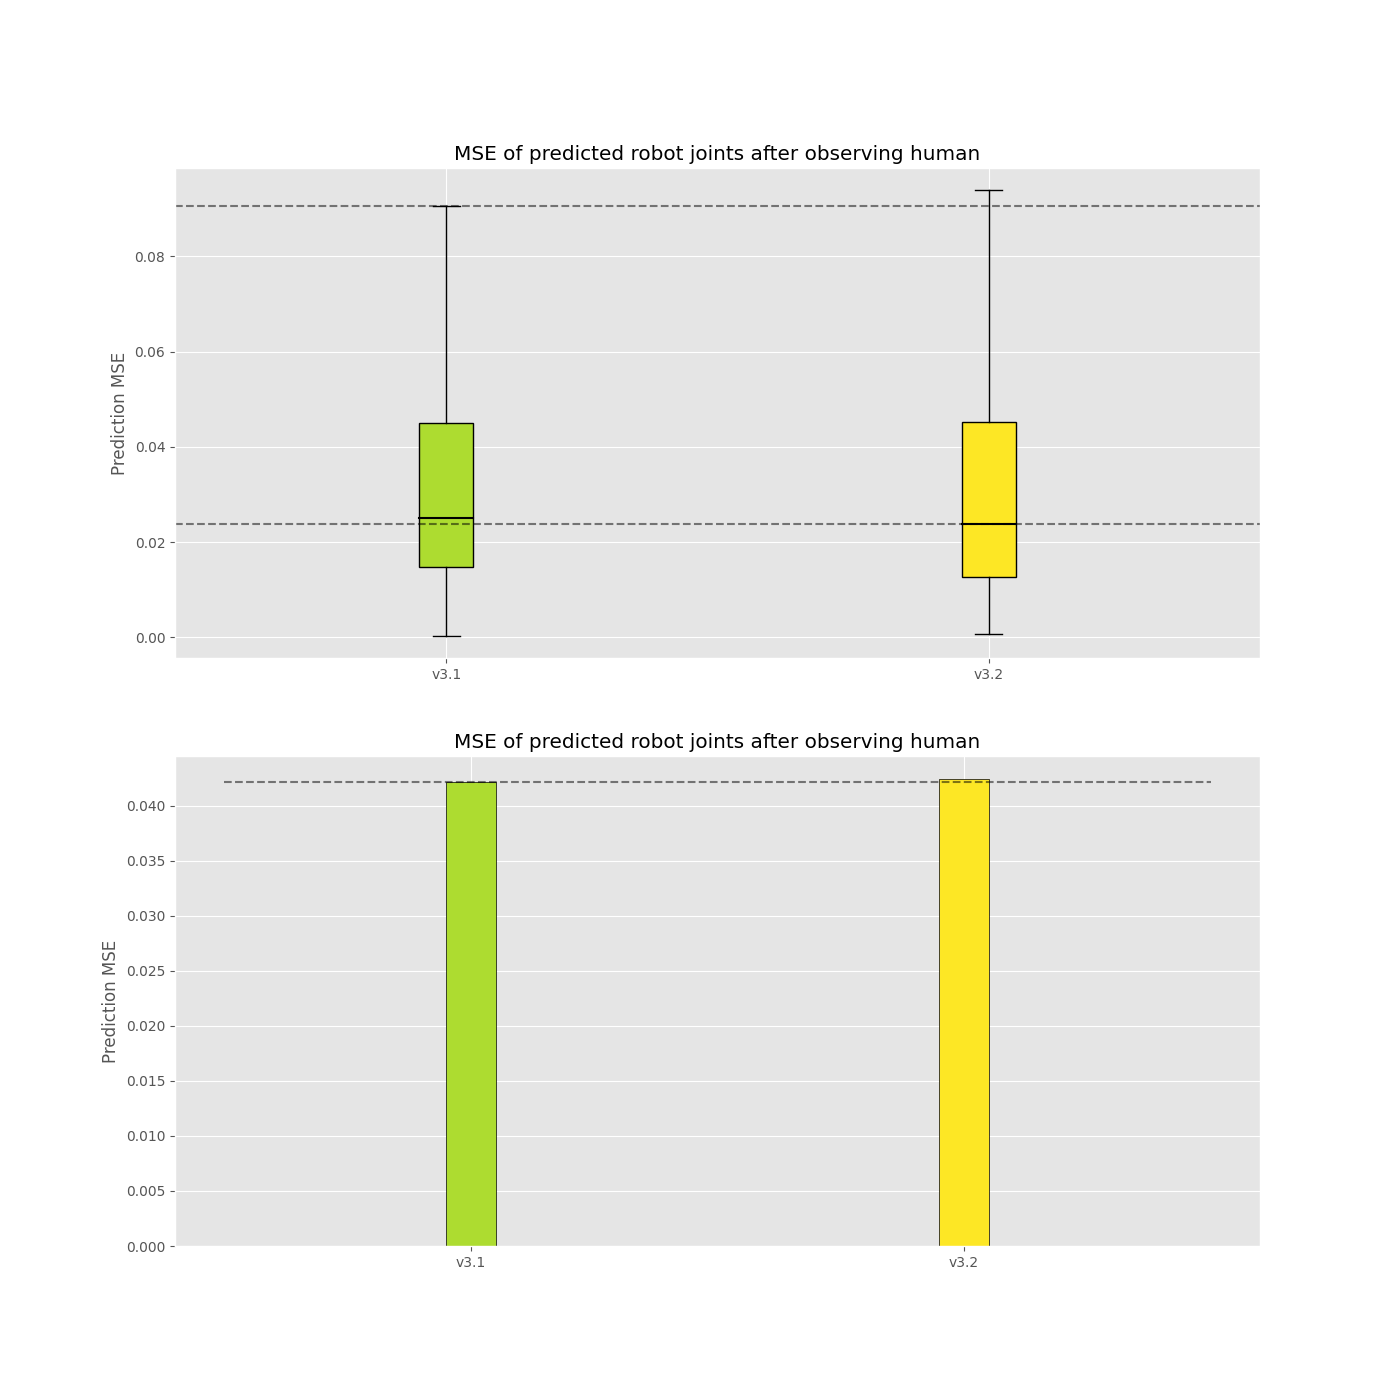

In [19]:
# p_values = np.ones((len(pred_mse), len(pred_mse)))
# models = model_types

# p_values = np.zeros((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
# 	for j in range(i+1,len(pred_mse)):
# 		p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i], pred_mse[j]).pvalue
# 		# if p_values[i,j]>0.05:
# 		# 	print(models[i],models[j],p_values[i,j])
# 		# 	p_values[i,j] = 0.051

# s = '\t'
# for i in range(len(models)):
# 	s+= models[i]+'\t'
# s+='\n'
# for i in range(len(pred_mse)):
# 	s+= models[i]+'\t'
# 	for j in range(len(pred_mse)):
# 		if j<=i:
# 			s += '.\t'
# 		else:
# 			if p_values[i,j] < 0.01:
# 				s += '**\t'
# 			elif p_values[i,j] < 0.05:
# 				s += '*\t'
# 			else:
# 				s += 'o\t'
# 	s+='\n'
# print(s)

fig = plt.figure(figsize=(14,14))
ax_box_pred = plt.subplot(2,1,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(2,1,2)
# p_plot = plt.subplot(3,1,3)
# heatmap = p_plot.pcolor(p_values)
# p_plot.colorbar(heatmap)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0
ax_box_pred.set_title('MSE of predicted robot joints after observing human')
ax_bar_pred.set_title('MSE of predicted robot joints after observing human')

# X = np.arange(len(pred_mse))
mean_pred_mse = np.array([np.mean(pred_mse[i]) for i in range(len(pred_mse))])
med_pred_mse = np.array([np.median(pred_mse[i]) for i in range(len(pred_mse))])

colors = get_cmap()(np.linspace(0.5,1,5))
labels = ['v1', 'v2.1', 'v2.2', 'v3.1', 'v3.2']
X = np.arange(5)
ax_bar_pred.bar(X[3:], mean_pred_mse[3:], color = colors[3:], width = 0.1, label=labels, edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X[1::3], mean_pred_mse[1::3], color = colors[1], width = 0.1, label=labels[1], edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X[2::3], mean_pred_mse[2::3], color = colors[2], width = 0.1, label=labels[2], edgecolor='k')#, label='100 epochs')
# ax_bar_pred.bar(X, med_pred_mse, color = 'm', width = 0.5, label='median')#, label='100 epochs')

ax_bar_pred.plot([X[3]-0.5, X[-1]+0.5], [mean_pred_mse[3:].min(), mean_pred_mse[3:].min()], 'k--', alpha = 0.5)#, label='100 epochs')

bars = []
min_whiskers_y = 10
max_whiskers_y = -10
for i in range(3,len(pred_mse)):
	# if i%3 == 0:
	# 	continue
	bars.append(ax_box_pred.boxplot(pred_mse[i], positions=[X[i]], showfliers=False, widths=[0.1], patch_artist = True,
		   boxprops = dict(facecolor=colors[i]), 
		   medianprops = dict(color = "black", linewidth = 1.5),
		   labels=[labels[i]]))
	if bars[-1]['caps'][1].get_ydata()[0] < min_whiskers_y:
		min_whiskers_y = bars[-1]['caps'][1].get_ydata()[0]
	if bars[-1]['caps'][1].get_ydata()[0] > max_whiskers_y:
		max_whiskers_y = bars[-1]['caps'][1].get_ydata()[0]
	
ax_box_pred.plot([X[3]-0.5, X[-1]+0.5], [med_pred_mse.min(), med_pred_mse.min()], 'k--', alpha = 0.5)#, label='100 epochs')
ax_box_pred.plot([X[3]-0.5, X[-1]+0.5], [min_whiskers_y, min_whiskers_y], 'k--', alpha = 0.5)#, label='100 epochs')

ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
ax_bar_pred.set_xticks(X[3:], labels[3:])#('Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.',))# 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', ))
ax_box_pred.set_xticks(X[3:], labels[3:])#('Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.',))# 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', ))


# count_j = 0
# for j in range(3,len(pred_mse)):
# 	count_k = 0
# 	for k in range(j+1,len(pred_mse)):
# 		if p_values[j,k]>=0.05:
# 			y, h, col = np.max([bars[j]['caps'][1].get_ydata()[0],bars[k]['caps'][1].get_ydata()[0]])+np.max([count_j,count_k])*0.0025+0.005, 0.0025, 'k'
# 			if p_values[j,k]<0.05:
# 				ax_box_pred.plot([X[j], X[j], X[k], X[k]], [y, y+h, y+h, y], lw=1.5, c=col, linestyle='-')
# 				# ax_box_pred.text((X[k]+X[j])*.5, y+h, "*", ha='center', va='bottom', color=col,fontweight='bold',fontsize=20)
# 			else:
# 				ax_box_pred.plot([X[j], X[j], X[k], X[k]], [y, y+h, y+h, y], lw=1.5, c=col, linestyle='--')
# 				# ax_box_pred.text((X[k]+X[j])*.5, y+h, "o", ha='center', va='bottom', color=col,fontweight='bold',fontsize=20)
# 			count_k += 1
# 			count_j += 1

plt.show()


# "MILD" - Standard VAE Loss
$$\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL}$$

The following  use an additional conditional reconstruction term $\mathcal{L}_{cond} = \mathbb{E}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)$
They mainly differ in how the expectation is calculated w.r.t $\boldsymbol{\hat{z}}^r_t$, specifically which distribution is used for Monte Carlo sampling. We then calculate the reconstruction loss for the sampled points.

# Cond. Samples
- Samples are drawn from the HMM conditional distribution.
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the posterior mean and sample $\boldsymbol{\hat{z}}^r_t$ from this.
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) \\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t \sim p(\boldsymbol{z}_t^r | q_t^h)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$

# Diagonalized Cond. Samples
Same as above but using the diagonalized form of the conditional distribution covariance
$$p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, diag(\boldsymbol{\hat{\Sigma}}^r_t))$$

# Posterior Sample Conditioning 
$$
{\color{magenta}\boldsymbol{z}^h_t} \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)\\
\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{z}}^r_t = \sum_{k=1}^K {\color{orange}\bar \alpha_i^t} [{\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{z}^h_t})]\\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t| \boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t | \boldsymbol{x}^h_t)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$


# "with Post. Cov."
This implies Conditioning with the Posterior Covariance
$$\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i} + {\color{magenta}\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})^{-1}$$